# Assignment #4: Linear Models and Decision Trees
## Foundations of Machine Learning
## Do Q1 and one other question.
### Advice: Reuse your code and code from lectures, package routine tasks into functions, make plans about how you'll carry out the analysis before jumping into writing code, and work as efficiently as possible

In [62]:
! git clone https://github.com/DS3001/assignment4

fatal: destination path 'assignment4' already exists and is not an empty directory.


**Q1.** This question is a case study for linear models and decision trees. The data are about car prices. In particular, they include:

  - `Price`, `Color`, `Seating_Capacity`
  - `Body_Type`: crossover, hatchback, muv, sedan, suv
  - `Make`, `Make_Year`: The brand of car and year produced
  - `Mileage_Run`: The number of miles on the odometer
  - `Fuel_Type`: Diesel or gasoline/petrol
  - `Transmission`, `Transmission_Type`:  speeds and automatic/manual


  

  




  

  1. Load `cars_hw.csv`. These data were really dirty, and I've already cleaned them a significant amount in terms of missing values and other issues, but some issues remain (e.g. outliers, badly scaled variables that require a log or arcsinh transformation). Clean the data however you think is most appropriate.


In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

cars_file = r'/content/assignment4/data/cars_hw.csv'
cars = pd.read_csv(cars_file)
cars.head()

,Unnamed: 0,Make,Make_Year,Color,Body_Type,Mileage_Run,No_of_Owners,Seating_Capacity,Fuel_Type,Transmission,Transmission_Type,Price
0,1,Volkswagen,2017,silver,sedan,44611,1st,5,diesel,7-Speed,Automatic,657000
1,2,Hyundai,2016,red,crossover,20305,1st,5,petrol,5-Speed,Manual,682000
2,3,Honda,2019,white,suv,29540,2nd,5,petrol,5-Speed,Manual,793000
3,4,Renault,2017,bronze,hatchback,35680,1st,5,petrol,5-Speed,Manual,414000
4,5,Hyundai,2017,orange,hatchback,25126,1st,5,petrol,5-Speed,Manual,515000


In [64]:
# get rid of unnamed
cars = cars.drop(['Unnamed: 0'], axis=1)

In [65]:
# variables of interest: Price, Color, Seating_Capacity, Body_Type, Make, Make_Year, Mileage_Run, Fuel_Type,
# Transmission, Transmission_Type

# clean price

print(cars['Price'].describe())

count    9.760000e+02
mean     7.410195e+05
std      3.673234e+05
min      1.880000e+05
25%      4.757500e+05
50%      6.665000e+05
75%      8.830000e+05
max      2.941000e+06
Name: Price, dtype: float64


<Axes: >

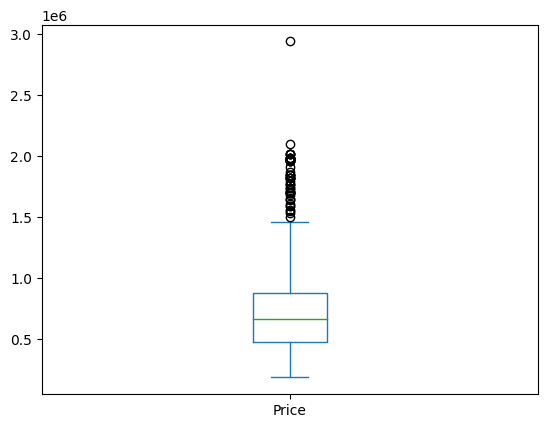

In [66]:
cars['Price'].plot.box()
# many outliers, going to remove some

<Axes: >

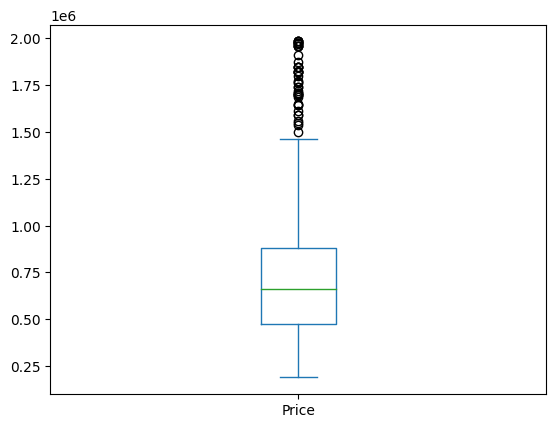

In [67]:
# arcsinh normalization might look a bit cleaner but I don't know how to work with it
# drop the outliers

cars = cars.loc[cars['Price']<2000000,:]
cars['Price'].plot.box()

In [68]:
# After price transformations, only 970 entries
# 'Color' looks fine
# 'Make' looks fine
# 'Seating_Capacity' looks fine
# 'Body_Type' looks fine
# transform 'Make_Year' to 'Age'

cars['Age'] = max(cars['Make_Year'])-cars['Make_Year']
cars['Age'].describe()

count    970.000000
mean       5.055670
std        2.816909
min        0.000000
25%        3.000000
50%        5.000000
75%        7.000000
max       11.000000
Name: Age, dtype: float64

<Axes: >

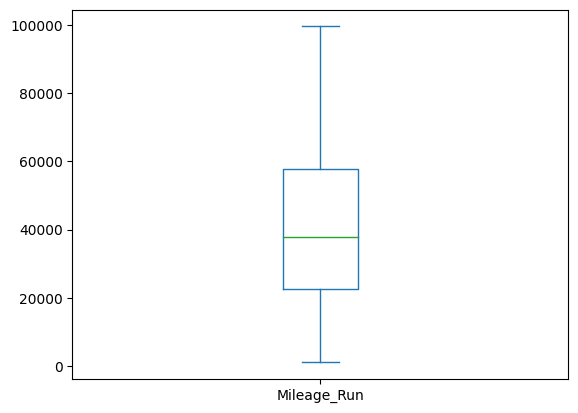

In [69]:
cars['Mileage_Run'].plot.box()
# nice!

In [70]:
# convert number of owners to numeric
# cars.loc[cars['No_of_Owners'] == '1st'] = 1
# cars.loc[cars['No_of_Owners'] == '2nd'] = 2
# cars.loc[cars['No_of_Owners'] == '3rd'] = 3
# cars['No_of_Owners'].unique()

#tempted to max-min normalize seating capacity but I think I'm gonna leave it

2. Summarize the `Price` variable and create a kernel density plot. Use `.groupby()` and `.describe()` to summarize prices by brand (`Make`). Make a grouped kernel density plot by `Make`. Which car brands are the most expensive? What do prices look like in general?

count    9.700000e+02
mean     7.320804e+05
std      3.493413e+05
min      1.880000e+05
25%      4.750000e+05
50%      6.630000e+05
75%      8.777500e+05
max      1.984000e+06
Name: Price, dtype: float64 



<Axes: xlabel='Price', ylabel='Density'>

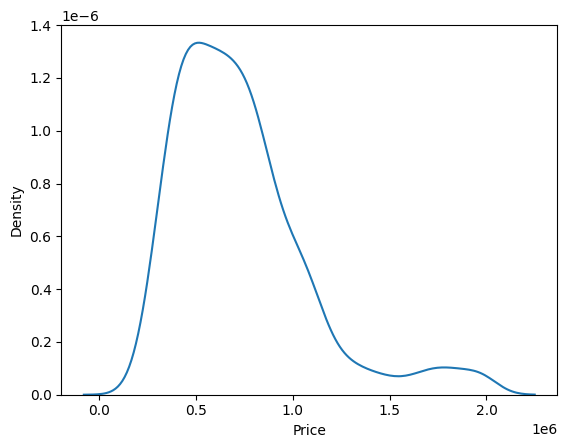

In [71]:
print(cars['Price'].describe(), '\n')
sns.kdeplot(data=cars, x='Price')

In [72]:
cars.loc[:,['Price','Make']].groupby('Make').describe()

Price                                                     \
               count          mean            std        min        25%   
Make                                                                      
Chevrolet        6.0  4.535000e+05  246606.366503   267000.0   288500.0   
Datsun           3.0  2.896667e+05   10503.967504   279000.0   284500.0   
Ford            52.0  7.211731e+05  140927.699605   290000.0   635000.0   
Honda           73.0  7.989726e+05  266509.066586   316000.0   581000.0   
Hyundai        305.0  6.918918e+05  279159.708519   248000.0   485000.0   
Jeep             4.0  1.499500e+06  152513.387391  1290000.0  1447500.0   
Kia              8.0  1.614750e+06  119056.709177  1369000.0  1579000.0   
MG Motors       31.0  1.850161e+06  115794.961541  1589000.0  1772000.0   
Mahindra        18.0  1.100167e+06  175549.305961   796000.0  1037000.0   
Maruti Suzuki  293.0  5.887850e+05  216019.860943   237000.0   411000.0   
Nissan           4.0  8.842500e+05  289559.867155   475000.0   782500.0   
Renault         68.0  6.625735e+05  214827.338943   287000.0   475000.0   
Skoda            4.0  6.847500e+05  411730.797974   436000.0   458500.0   
Tata            22.0  1.007727e+06  521201.010654   188000.0   776750.0   
Toyota          50.0  8.003400e+05  246689.973986   368000.0   526250.0   
Volkswagen      29.0  6.058276e+05  119831.151735   402000.0   542000.0   

                                                
                     50%        75%        max  
Make                                            
Chevrolet       345500.0   537500.0   892000.0  
Datsun          290000.0   295000.0   300000.0  
Ford            707500.0   787000.0  1066000.0  
Honda           785000.0   915000.0  1537000.0  
Hyundai         638000.0   837000.0  1742000.0  
Jeep           1529500.0  1581500.0  1649000.0  
Kia            1628500.0  1705750.0  1741000.0  
MG Motors      1848000.0  1968000.0  1984000.0  
Mahindra       1094500.0  1157000.0  1465000.0  
Maruti Suzuki   527000.0   764000.0  1163000.0  
Nissan          978000.0  1079750.0  1106000.0  
Renault         644000.0   801000.0  1164000.0  
Skoda           502000.0   728250.0  1299000.0  
Tata            863500.0  1302750.0  1972000.0  
Toyota          894000.0  1023000.0  1092000.0  
Volkswagen      607000.0   699000.0   790000.0

<Axes: xlabel='Price', ylabel='Density'>

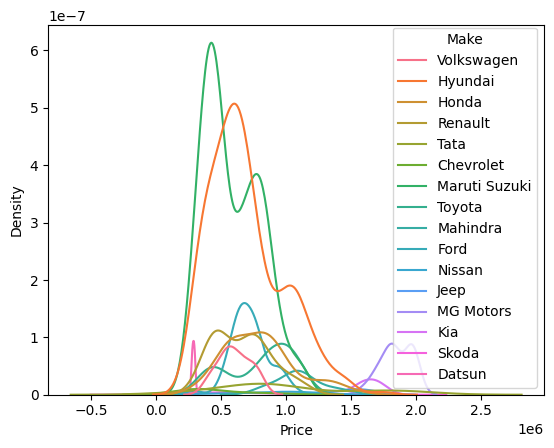

In [73]:
sns.kdeplot(data=cars, x='Price', hue = 'Make')

In [74]:
# In general, prices are densest between 500,000 and 1,000,000. Most vehicle prices are concentrated there.
# The most expensive vehicles seem to be produced by MG Motors, with Jeeps and Kias being similarly pricey.
# others include Tata (high variance) and Mahindra (slightly cheaper)
# Can see this from minimums (first 3 all above 1mil), means (first 3 all above 1.5mil) and kde distribution

 3. Split the data into an 80% training set and a 20% testing set.

In [75]:
# basic split

from sklearn.model_selection import train_test_split
cars_train, cars_test = train_test_split(cars,test_size=.2,random_state=5)

4. Let's focus on linear models. Make a model where you regress price on the numeric variables alone; what is the $R^2$ and `RMSE` on the test set? Make a second model where, for the categorical variables, make a model comprised of one-hot encoded regressors/features alone, and regress price on those variables; what is the $R^2$ and `RMSE` on the test set? Which model performs better on the test set? Make a third model that combines all the regressors from the previous two; what is the $R^2$ and `RMSE` on the test set? Does the joint model perform better or worse, and by home much?

In [76]:
# create quick lil function to help print rmse and r^2

def print_stuff(r2, rmse):
  print('R^2: ' + str(r2), '\n')
  print('RMSE: ' + str(rmse), '\n')
  return

In [77]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score


# numeric values only
num_train = cars_train.select_dtypes(include='number')
x_train_num = num_train.drop('Price', axis=1)
y_train_num = num_train['Price']

num_test = cars_test.select_dtypes(include='number')
x_test_num = num_test.drop('Price', axis=1)
y_test_num = num_test['Price']

# create model
model_num = LinearRegression()
model_num.fit(x_train_num, y_train_num)
y_pred_num = model_num.predict(x_test_num)
r2_num = r2_score(y_test_num, y_pred_num)
rmse_num = np.sqrt(mean_squared_error(y_test_num, y_pred_num))
print_stuff(r2_num, rmse_num)

R^2: 0.4059059621243539 

RMSE: 232222.57370218035 



In [78]:
# r^2 = 0.40126, rmse = 233129.5

In [79]:
# categorical values only
cat_train = cars_train.select_dtypes(include='object')
x_train_cat = pd.get_dummies(cat_train)
cols = x_train_cat.columns.tolist() # store cols
y_train_cat = cars_train['Price']

# categorical test values
cat_test = cars_test.select_dtypes(include='object')
x_test_cat = pd.get_dummies(cat_test)
x_test_cat = x_test_cat.reindex(columns=cols).fillna(0)
y_test_cat = cars_test['Price']

# create model
model_cat = LinearRegression()
model_cat.fit(x_train_cat, y_train_cat)
y_pred_cat = model_cat.predict(x_test_cat)
r2_cat = r2_score(y_test_cat, y_pred_cat)
rmse_cat = np.sqrt(mean_squared_error(y_test_cat, y_pred_cat))
print_stuff(r2_cat, rmse_cat)

R^2: 0.6619876945062584 

RMSE: 175163.2895644848 



In [80]:
# join the jaunts
x_train_combo = x_train_num.join(x_train_cat)
x_test_combo = x_test_num.join(x_test_cat)
# no need to change the y it's already set up well enough

# create da model
model_combo = LinearRegression()
model_combo.fit(x_train_combo, y_train_cat)
y_pred_combo = model_combo.predict(x_test_combo)
r2_combo = r2_score(y_test_cat, y_pred_combo)
rmse_combo = np.sqrt(mean_squared_error(y_test_cat, y_pred_combo))
print_stuff(r2_combo, rmse_combo)

R^2: 0.8063336840715263 

RMSE: 132587.89710460303 



In [81]:
# dope news: most accurate model by far is the combined model
# r^2 of .8 seems pretty solid to me
# I would say it performs quite significantly better than both cat and num
# with num being the worst predictor by a good margin

  5. Use the `PolynomialFeatures` function from `sklearn` to expand the set of numerical variables you're using, along with the categorical variables. As you increase the degree of the expansion, how do the $R^2$ and `RMSE` change? At what point does $R^2$ go negative on the test set? For your best model with expanded features, what is the $R^2$ and `RMSE`? How does it compare to your best model from part 3?

In [82]:
from sklearn.preprocessing import PolynomialFeatures, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
# tbh I do not really understand pipelines
# so I used ChatGPT for guidance on setting this one up

cars_train = cars_train.drop(['Price'], axis=1)
cars_test = cars_test.drop(['Price'], axis=1)

# useful function to automate the model training section
def train_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    return r2, rmse

numeric_features = cars_train.select_dtypes(include=['number'])
num_cols = numeric_features.columns
categorical_features = cars_train.select_dtypes(include=['object'])
cat_cols = categorical_features.columns

for i in range (20):
  num_pipeline = Pipeline([
      ('degrees', PolynomialFeatures(degree=i+1, include_bias=False))])
  comb_pipeline = ColumnTransformer([
      ('num', num_pipeline, num_cols),
      ('cat', OneHotEncoder(), cat_cols)
  ])
  cars_train_new = comb_pipeline.fit_transform(cars_train)
  cars_test_new = comb_pipeline.transform(cars_test)

  model = LinearRegression()
  r2, rmse = train_model(model, cars_train_new, y_train_cat, cars_test_new, y_test_cat)


  print('Model ' + str(i+1), '\n')
  print_stuff(r2, rmse)


Model 1 

R^2: 0.7934003223123145 

RMSE: 136943.57361973447 

Model 2 

R^2: 0.8143243174991515 

RMSE: 129823.81031892239 

Model 3 

R^2: 0.7394041077534216 

RMSE: 153801.51727031262 

Model 4 

R^2: 0.37185007448366214 

RMSE: 238785.7980819838 

Model 5 

R^2: 0.3857152758046032 

RMSE: 236135.7240723667 

Model 6 

R^2: -30.89660602260073 

RMSE: 1701567.0774668357 

Model 7 

R^2: -0.4033920563414708 

RMSE: 356916.2686049961 

Model 8 

R^2: 0.11215206054563032 

RMSE: 283887.40996808716 

Model 9 

R^2: -10.606250542266572 

RMSE: 1026414.5687268531 

Model 10 

R^2: -1.2951491659591543 

RMSE: 456438.52704740776 

Model 11 

R^2: -0.08993577115151252 

RMSE: 314541.0194889271 

Model 12 

R^2: 0.021530971688385914 

RMSE: 298023.4093710287 

Model 13 

R^2: -0.3238760752353571 

RMSE: 346657.42275087157 

Model 14 

R^2: -29.69700877747961 

RMSE: 1669263.380747173 

Model 15 

R^2: -46.89492396175859 

RMSE: 2085074.5195816087 

Model 16 

R^2: -23.979223881924266 

RMSE: 1

In [83]:
# r^2 goes negative at model 6
# best model = model 2
# r^2 = 0.8143, rmse = 129824
# versus best combined model: R^2 = 0.8063336840715263 RMSE = 132587.89710460303
# looks like a marginal but beneficial improvement to me

 6. For your best model so far, determine the predicted values for the test data and plot them against the true values. Do the predicted values and true values roughly line up along the diagonal, or not? Compute the residuals/errors for the test data and create a kernel density plot. Do the residuals look roughly bell-shaped around zero? Evaluate the strengths and weaknesses of your model.

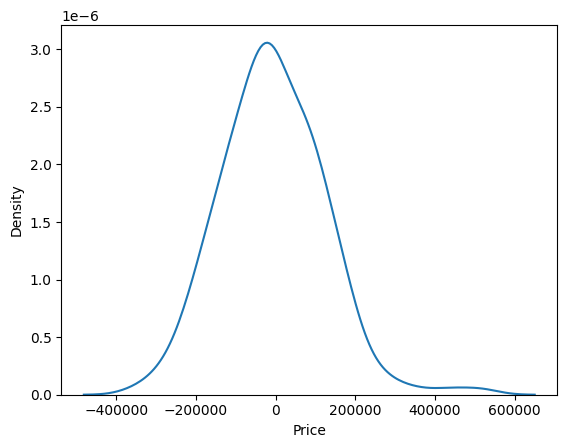

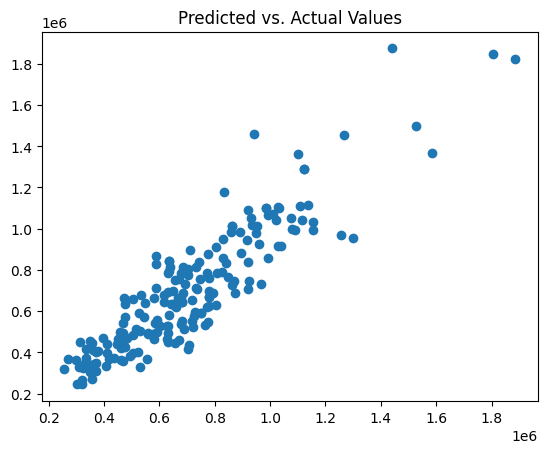

In [84]:
num_pipeline = Pipeline([
    ('degrees', PolynomialFeatures(degree=2, include_bias=False))])
comb_pipeline = ColumnTransformer([
    ('num', num_pipeline, num_cols),
    ('cat', OneHotEncoder(), cat_cols)
])
cars_train_new = comb_pipeline.fit_transform(cars_train)
cars_test_new = comb_pipeline.transform(cars_test)

model = LinearRegression()
model = model.fit(cars_train_new, y_train_cat)
y_pred = model.predict(cars_test_new)

residuals = y_test_cat - y_pred
sns.kdeplot(residuals)
plt.show()

## True versus predicted plot:
plt.scatter(x=y_pred,y=y_test_cat)
plt.title('Predicted vs. Actual Values')
plt.show()

In [ ]:
# That actually looks pretty good!
# can certainly see the effects of outliers:
# more accurate in the lower price ranges
# slightly uneven residuals (tendency toward overestimation just a bit)

  7. Now, let's use a regression tree. Construct an appropriate matrix of regressors/features, and fit a tree to the data. Vary the maximum depth of the decision tree using the `max_depth` option (i.e. `tree.DecisionTreeRegressor(max_depth=D)`), and compute the $R^2$ and `RMSE` on the test set of a variety of depths. What depth tree gives the best results?

In [87]:
from sklearn import tree
for depth in range(20):
  cars_tree = tree.DecisionTreeRegressor(max_depth=depth+1)
  cars_tree = cars_tree.fit(cars_train_new, y_train_cat)

  y_pred = cars_tree.predict(cars_test_new)

  r2 = r2_score(y_test_cat, y_pred)
  rmse = np.sqrt(mean_squared_error(y_test_cat, y_pred))
  print('Depth ' + str(depth+1), '\n')
  print_stuff(r2, rmse)

Depth 1 

R^2: 0.32705728477698537 

RMSE: 247152.99925330657 

Depth 2 

R^2: 0.4875467741551812 

RMSE: 215677.058936833 

Depth 3 

R^2: 0.6967050704130093 

RMSE: 165924.07759189836 

Depth 4 

R^2: 0.7630288390469399 

RMSE: 146664.35786469697 

Depth 5 

R^2: 0.796017384514594 

RMSE: 136073.45596248828 

Depth 6 

R^2: 0.7123211608520756 

RMSE: 161596.07045853965 

Depth 7 

R^2: 0.7926005269031204 

RMSE: 137208.38779184836 

Depth 8 

R^2: 0.8102852495230023 

RMSE: 131228.26485913305 

Depth 9 

R^2: 0.7233053741631582 

RMSE: 158480.9985908767 

Depth 10 

R^2: 0.7911758047510554 

RMSE: 137678.85489998563 

Depth 11 

R^2: 0.7819151709836634 

RMSE: 140698.53147787464 

Depth 12 

R^2: 0.8005198795226086 

RMSE: 134563.30582822728 

Depth 13 

R^2: 0.7854770460635382 

RMSE: 139544.8204624227 

Depth 14 

R^2: 0.784773947430236 

RMSE: 139773.3123563973 

Depth 15 

R^2: 0.7944811307707113 

RMSE: 136584.8996434514 

Depth 16 

R^2: 0.7843728703080234 

RMSE: 139903.486618

In [ ]:
# best score is at depth = 8
# r^2 = 0.810
# rmse = 131228

  8. For your best tree, determine the predicted values for the test data, and plot them against the true values. Do the predicted values and true values line up along the diagonal, or not? Compute the residuals/errors for the test data and create a kernel density plot. Do the residuals look roughly bell-shaped around zero?

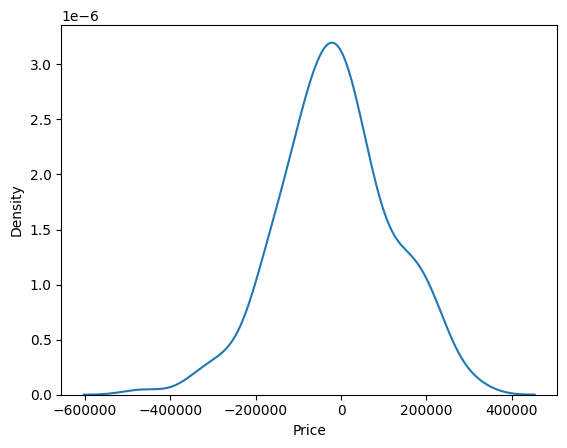

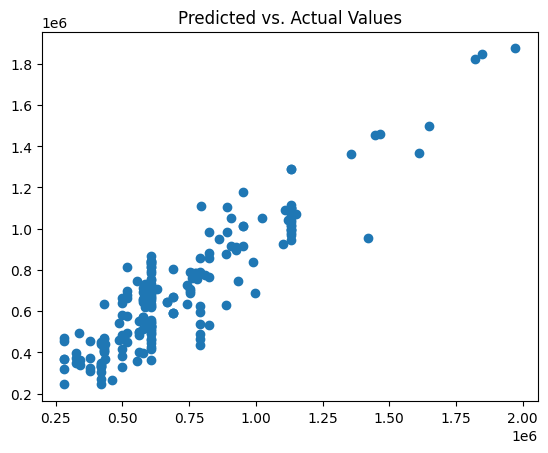

In [89]:
best_model = tree.DecisionTreeRegressor(max_depth=8)
best_model = best_model.fit(cars_train_new, y_train_cat)
best_pred = best_model.predict(cars_test_new)

residuals = y_test_cat - best_pred
sns.kdeplot(residuals)
plt.show()

## True versus predicted plot:
plt.scatter(x=best_pred,y=y_test_cat)
plt.title('Predicted vs. Actual Values')
plt.show()

In [ ]:
# seems to do adequately well.
# doesn't line up quite as well due to style of regression tree
# limited opportunities for variance in the predictions from the model
# but pretty good shape overall with a few major outliers
# could be fine tuned a bit more

9. Which model --- linear model or classification and regression tree --- has better performance on the test set?

I would say that overall, the linear model fits the test set better than the classification/regression tree. Though the r^2 values and RMSEs are extremely close to each other for the optimal models of each version, the linear model I think is more effective for a numeric outcome. This is reflected in the marginally better r^2 and RMSE values, but also in how the predictions of the tree tended to stack up. The tree might be useful for ballparking, but is not noticeably more effective at controlling for outliers on the higher end of the outcome scale. For these reasons, I would prefer a linear model for determining the price outcome. It's also likely that further normalization and outlier elimination would have been beneficial, but that's a bit much for me.

**Q2.** The is a question about regression using decision trees and linear models. The data include wages at data science-y jobs, including

  - `Rating`: Company worker happiness score
  - `Size`: Number of employees
  - `Sector`: Part of the economy
  - `avg_salary`: Average wage
  - `job_state`: Location of work

  1. Load the `wages_hw.csv` file. Split the sample into an ~80% training set and a ~20% test set. Do any necessary cleaning, including outliers and missings.
  2. Use a linear model to regress `avg_salary` on `Sector`. Which sectors have the highest predicted wages? What is the $R^2$ and `RMSE` on the test set?
  3. Make a scatterplot of `avg_salary` and `Rating`. Is there an obvious visual relationship between the two variables? Regress `avg_salary` on `Rating` as a numeric variable: Do higher ratings predict higher or lower wages? Convert `Rating` to a one-hot encoded variable, with a category for each rating. Run a regression of `avg_salary` on the categorical version. How do your results change? Explain. Which version has a higher $R^2$ and lower `RMSE`?
  4. Now interact `Sector` with the categorical version of `Rating`, so your regressors are a (Sector, Rating) pair; this is a programming puzzle you'll have to think about, but using the `.PolynomialFeatures()` function on the one-hot encoded categorical variables is one option, and another is pre-processing a new variable that interacts `Sector` and `Rating` and then one-hot encoding the result. Regress `avg_salary` on the (Sector, Rating) pairs. How does the $R^2$ and `RMSE` on the test set compare to part 2? Interpret the coefficients; which sector-rating pairs have the highest wages?
  5. Run a linear regression of `avg_salary` on all the variables. What is the $R^2$ on the test set? How does it compare to your simpler models in 2--4?
  6. Build a decision tree by regressing `avg_salary` on `Sector`, `Rating`, and the (Sector, Rating) pairs. What are the $R^2$ and `RMSE` of your models on the test set? How do your answers compare to parts 2, 3, and 4?
  7. Build a decision tree by regressing `avg_salary` on all the other variables. What is the $R^2$ and `RMSE` on the test set?
  8. Build a linear regression or decision tree using the available variables based on your own judgment. What degrees of freedom are you giving the model to predict variation in wages across company and location attributes? What is the $R^2$ and `RMSE` of your model? How does it compare to the previous ones in the question? Why does yours perform better or worse on the test set?

**Q3.** This a question purely on categorical prediction. The data for this happen to be gathered in 1987 in Indonesia, and concern contraceptive method choice. The questions and data-gathering assumptions reflect the culture and attitudes of that time and place, but provide a good example of a categorical prediction problem on an important topic (family planning and maternal health The variables in the data are:

    - Wife's age (numerical)
    - Wife's education (categorical) 1=low, 2, 3, 4=high
    - Husband's education (categorical) 1=low, 2, 3, 4=high
    - Number of children ever born (numerical)
    - Wife's religion (binary) 0=Non-Islam, 1=Islam
    - Wife's now working? (binary) 0=Yes, 1=No
    - Husband's occupation (categorical) 1, 2, 3, 4
    - Standard-of-living index (categorical) 1=low, 2, 3, 4=high
    - Media exposure (binary) 0=Good, 1=Not good
    - Contraceptive method used (class attribute) 1=No-use, 2=Long-term, 3=Short-termhort-term

  



  5. Compute a confusion matrix for your classification tree on the test set (Hint: There are now three categories instead of two, so the cross tabulation will be a $3 \times 3$ matrix instead of $2 \times 2$.). Compute the Accuracy of your model overall, and the Accuracy for predicting each contraceptive method.
  7. Why can't you use a linear probability model to do this exercise? Explain clearly in words.

1. Load the `contraceptiveMethodChoice.csv` data. Tabulate the `method` variable (i.e. `.value_counts()`). 1 corresponds to `No Contraception`, 3 corresponds to `Short Term` (e.g. condoms, birth control pills), and 2 corresponds to `Long Term` (e.g. IUD, sterilization). Cross tabulate `method` and `numberChildren`. Do couples that use birth control tend to have more children than those who don't?

In [90]:
contra_file = r'/content/assignment4/data/contraception_hw.csv'
contra = pd.read_csv(contra_file)
contra.head()

,Unnamed: 0,age,edu,edu_spouse,numberChildren,religion,working,spouse_occupation,standardOfLivingIndex,mediaExposure,method
0,1,24,2,3,3,1,1,2,3,0,1
1,2,45,1,3,10,1,1,3,4,0,1
2,3,43,2,3,7,1,1,3,4,0,1
3,4,42,3,2,9,1,1,3,3,0,1
4,5,36,3,3,8,1,1,3,2,0,1


In [94]:
# get rid of useless column
contra = contra.drop(['Unnamed: 0'], axis=1)
print(contra.head())
# tabulate
contra['method'].value_counts()

KeyError: ignored

In [92]:
pd.crosstab(contra['method'],contra['numberChildren'])

numberChildren,0,1,2,3,4,5,6,7,8,9,10,11,12,13,16
method,,,,,,,,,,,,,,,
1,95,143,114,70,57,44,35,18,29,5,9,6,4,0,0
2,0,46,56,70,62,36,27,19,9,3,2,2,0,1,0
3,2,87,106,119,78,55,30,12,9,8,0,3,0,1,1


Interestingly, the couples who use more short- and long- term birth control tend to have an in-between number of kids (more people with between 2-7 kids use some form of brith control than not, while people with less than 2 kids or more than 8 are more likely to use no form of birth control). This is not a perfect assessment but is generally true.

  2. Split the sample into ~80% training data and ~20% testing data.

In [112]:
x = contra.drop('method', axis=1)
y = contra['method']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

  3. We are now going to make a mistake. Train a regression tree to predict the contraceptive method using the other variables in the data, not a classification tree. Look at the terminal nodes in the tree: What values do they take? Does that make sense? Explain clearly what has gone wrong here.

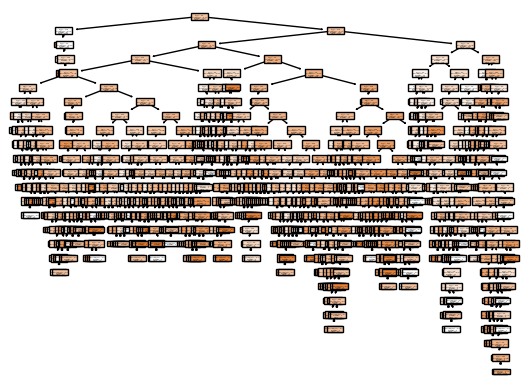

In [107]:
model = tree.DecisionTreeRegressor()
bad_model = model.fit(x_train, y_train)
tree.plot_tree(bad_model, filled=True)
plt.show()

Most obvious issue is that there was no max depth set, so the tree just went deeper and deeper until every value was separated (classic case of overfit). Likely if we applied this to a test set, it would be a disaster. Furthermore, the regression tree is not really built to deal with categorical variables, but numerical ones. It's really ugly to look at the nodes, because the values they take are decimals despite most variable types being categorical: it is trying to interpret things on a continuum that does not exist.

  4. Instead of regression, use a classification tree to predict contraceptive method using the other variables in the data. How does it look different from the previous tree? What variables does the algorithm use? In broad terms, which groups of people are most likely to use each method of contraception?

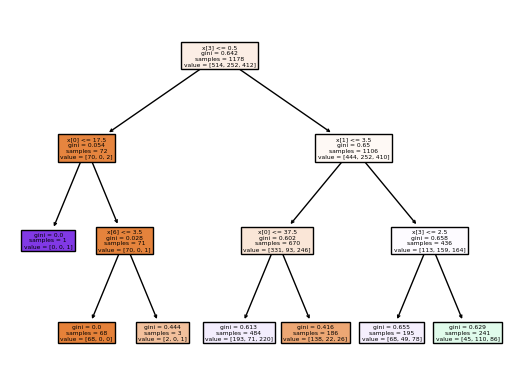

In [115]:
good_model = tree.DecisionTreeClassifier(max_depth = 3)
good_model = good_model.fit(x_train, y_train)
tree.plot_tree(good_model, filled=True)
plt.show()

**Q4.** This is a question where we use regression and regression trees. The outcome is whether a defendant is held pre-trial in the Virginia justice system. We would like to understand how that outcome is predicted by characteristics of the defendant, particularly race. Let's be very careful/clear: We aren't saying anyone *should* be held without bond or asserting that people with different demographic variables *should* be more likely to be held, but instead trying to predict whether people with different characteristics *are empirically more likely* to be held without bond, given the available information. This is the first step we would take in investigating whether a system is fair, or how large the disparities are: Does it treat people with similar observable characteristics similarly, or not? We are going to look at a common question: Are Black defendants treated differently from white or Asian ones? (There are Native American defendants, but there are 11 in total, which is such a small number of observations that is difficult to clearly say anything about how this group is treated relative to the others.)

The variables in the data are:

  - `held_wo_bail`: Whether a defendant is held without bail before trial (Boolean logical)
  - `race`, `sex`: Categorical demographic variables
  - `is_poor`: Whether the defendant is classified as indigent
  - `prior_F`, `prior_M`: The number of prior felony and misdemeanor arrests
  - `case_type`: A categorical variable indicating a misdemeanor `M` or felony `F` or infraction `I` or special case `S`
  - `age`: Defendant's age
  - `bond`, `bond_NA`, `bond_type`: The amount of any bond, whether it is missing, and the type
  - `sentence`, `sentence_NA`, `sentence_type`: The length of any sentence, whether it is missing, and the type

1. Load the `pretrial_data.csv` data. Notice that there are `nan`s, but the data are relatively clean. Because there are `.nan`s among variables you won't use, you'll want to narrow down your analysis to the relevant variables before dropping or imputing missing values.
2. Create a dummy variable indicating that the defendant is Black.
3. Regress `held` on `Black`. What is the slope coefficient Interpret the coefficient on the Black dummy variable: How much more likely is a black person to be held without bail? What is the $R^2$ of the model?
4. Before doing this question, please think for a few minutes about how to make the process of running these regressions as efficient as possible, before jumping into writing code. Repeat part 2, for the following specifications, keeping track of the coefficient on the Black dummy variable each time:
      - `held` on `Black` and `sex`
      - `held` on `Black` and `sex` and `is_poor`
      - `held` on `Black` and `sex` and `is_poor` and `prior_F`
      - `held` on `Black` and `sex` and `is_poor` and `prior_F` and `case_type`
What happens to the coefficient on the Black dummy variable as you include more regressors/features/controls in the regression? Explain your findings.
5. Suppose we don't want to see just `Black` and `sex`, but `Black` interacted with `sex`: Are Black men and Black women treated systemically differently from the rest of the population? Implement this in a regression, and explain your findings.
6. Imagine someone argued we should use these kinds of models to help a judge or magistrate make bail decisions (you could obviously go back and make this kind of model for the bond and sentence variables, then deploy it on new cases to predict what their bond and sentence values would be). What concerns would you have? Do you think society should be using data-driven and automated tools like that? Explain your concerns clearly.

**Q5.** This is a math question to review the derivation of the OLS estimator (but only if you are into that kind of thing!). We are going to do it slightly differently from what we did in class, though. We will use a linear predictor and minimize the Sum of Squared Errors, just as in class. But, we are going to de-mean $X$ first, creating another variable $z_i = x_i - \bar{x}$ where
$$
\bar{x} = \dfrac{1}{N} \sum_{i=1}^N x_i,
$$
so the model is $\hat{y}_i = a + b z_i$ and the `SSE` is
$$
\text{SSE}(a,b) = \sum_{i=1}^N (y_i - a - bz_i)^2.
$$

  1. Take partial derivatives of the `SSE` with respect to $a$ and $b$. You should get

\begin{eqnarray*}
\sum_{i=1}^N -2(y_i - a- bz_i) &=& 0 \\
\sum_{i=1}^N -2(y_i - a - bz_i)z_i &=& 0.
\end{eqnarray*}

  2. Solve for the solutions to the above equations. Big hint: $\bar{z} = 0$, since we subtracted the mean of $x$ from $x$ to get $z$. You should get

\begin{eqnarray*}
a^* &=& \bar{y} \\
b^* &=& \dfrac{\sum_{i=1}^N(y_i - \bar{y})z_i}{\sum_{i=1}^N z_i^2}.
\end{eqnarray*}

  3. Substitute $z_i = x_i - \bar{x}$ back into the above equations. You should get
  
\begin{eqnarray*}
a^* &=& \bar{y} \\
b^* &=& \dfrac{\sum_{i=1}^N(y_i - \bar{y})(x_i-\bar{x})}{\sum_{i=1}^N (x_i-\bar{x})^2},
\end{eqnarray*}

which can be written in terms of sample covariance and sample variance as:

\begin{eqnarray*}
a^* &=& \bar{y} \\
b^* &=& \dfrac{\text{cov}(x,y)}{\text{var}(x)}.
\end{eqnarray*}

This is typically the preferred way of expressing the OLS coefficients.

4. When will $b^*$ be large or small, depending on the relationship between $x$ and $y$ and the amount of "noise"/variance in $x$? What does $a^*$ represent?
5. Suppose you have measurement error in $x$ which artificially inflates its variance (e.g. bad data cleaning). What happens to the $b^*$ coefficient? How will affect your ability to predict? (This phenomenon is called **attenuation**.)
6. Let's return to the question of *outliers*. With your formula for the OLS coefficients $(a^*,b^*)$, explain what happens if you significantly increase a single value of the outcome/target/response variable $y_i$ or one of the predictor/explanatory/covariate variables $x_i$. If values for some extreme observations are exerting significant influence over the regression coefficients, will the model perform well on for more average observations?